# The Weight of Words When You Are Judged

In [1]:
import pandas as pd
from tqdm.auto import tqdm

## Data Import

In [2]:
import json

# Open json file, transform it in a collection of objects
# and retrieve a list of court decisions
with open('Data/data.jsonl') as f:
    data = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + 
    "]")

In [3]:
# Number of court decisions
len(data)

183146

In [4]:
# Retrieve each opinion and relevant metadata
opinions = []

for cd in data:
    identifier = cd['id']
    name = cd['name_abbreviation']
    year = cd['decision_date'][:4]
    
    for op in cd['casebody']['data']['opinions']:
        opinion = op['text']
        
        opinions.append([identifier, name, year, opinion])

In [5]:
# Total number of opinions
len(opinions)

194366

In [6]:
# Convert to pandas dataframe
opinions = pd.DataFrame(opinions, columns=['id', 'name', 'year', 'opinion'])
opinions['year'] = opinions['year'].astype('int')
opinions.head()

,id,name,year,opinion
0,544894,In re Marriage of Lappe,1997,JUSTICE BILANDIC\ndelivered the opinion of the...
1,544894,In re Marriage of Lappe,1997,"JUSTICE FREEMAN,\ndissenting:\nJurisdiction is..."
2,544872,People v. Pulliam,1997,CHIEF JUSTICE HEIPLE\ndelivered the opinion of...
3,544872,People v. Pulliam,1997,"JUSTICE HARRISON,\ndissenting:\nThe trial cour..."
4,544855,People v. Smith,1997,JUSTICE HARRISON\ndelivered the opinion of the...


## Text Preprocessing

In [7]:
import string
import contractions
from string import digits

punct = string.punctuation

def text_preproc(text):
    """
    text: string to preprocess
    
    Normalize the input, lower characters, extend contractions, 
    remove functional punctuation and digits.
    Return the modified text.
    """
    
    text = text.replace('\n', ' ')
    text = text.lower()
    text = contractions.fix(text)
    
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    
    text = "".join([char for char in text if char not in punct])    
        
    return text

In [8]:
tqdm.pandas()
opinions['opinion'] = opinions['opinion'].progress_apply(lambda x: text_preproc(x))

  0%|          | 0/194366 [00:00<?, ?it/s]

In [9]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

lemmatizer = WordNetLemmatizer()

def lemmatization(text):
    """
    text: document to lemmatize
    
    Retrieve each word and the respective 
    position tag. Use the WordNet lemmatizer
    with these information.
    Return a list of lemmas.
    """
    
    tokens = pos_tag(word_tokenize(text))
    
    doc = []
    
    for word, tag in tokens:
        if tag[0] in ['A', 'R', 'N', 'V']:
            lemma = lemmatizer.lemmatize(word, tag[0].lower())
            doc.append(lemma)
        else:
            doc.append(word)
        
    return doc

In [10]:
opinions['tokens'] = opinions['opinion'].progress_apply(lambda x: lemmatization(x))

  0%|          | 0/194366 [00:00<?, ?it/s]

In [11]:
opinions['tokens'].head()

0    [justice, bilandic, deliver, the, opinion, of,...
1    [justice, freeman, dissent, jurisdiction, be, ...
2    [chief, justice, heiple, deliver, the, opinion...
3    [justice, harrison, dissent, the, trial, court...
4    [justice, harrison, deliver, the, opinion, of,...
Name: tokens, dtype: object

## Word2Vec

In [12]:
# Transform data for being a proper input to w2v model
docs = opinions['tokens'].tolist()

In [13]:
from gensim.models import Word2Vec

# Train the Word2Vec model
model = Word2Vec(docs, vector_size=150, min_count=2, sg=0, epochs=10, seed=22)

In [14]:
# Size of the dictionary
len(model.wv.key_to_index)

242779

In [15]:
# Example of the 10 words most similar to 'cocaine'
model.wv.most_similar('cocaine', topn=10)

[('heroin', 0.9423210024833679),
 ('marijuana', 0.8962147235870361),
 ('lsd', 0.8342110514640808),
 ('narcotic', 0.8088869452476501),
 ('cannabis', 0.7971652746200562),
 ('pcp', 0.7862935662269592),
 ('amphetamine', 0.7499281167984009),
 ('drug', 0.7285762429237366),
 ('methamphetamine', 0.7227038145065308),
 ('gram', 0.7026399970054626)]

In [16]:
def similar_terms(words, threshold=0.6):
    """
    words: list of words
    threshold: value of minimum similarity
    
    For each word in the list, find which are the
    most similar terms according to the similarity
    threshold.
    Return a list of similar terms.
    """
    
    vocab = model.wv.index_to_key
    terms = []
    
    for w in words:
        terms.append(w)
        sim = model.wv.most_similar(w, topn=None)
        for idx, s in enumerate(sim):
            if s > threshold:
                terms.append(vocab[idx])
                
    return set(terms)

In [17]:
# Selected list of terms
n = ['cannabis', 'cocaine', 'methamphetamine', 'drug', 'alcohol',
     'marijuana', 'mdma', 'lsd', 'ketamine', 'heroin', 'fentanyl']

w = ['gun', 'knife', 'weapon', 'firearm', 'rifle', 'carbine', 'pistol',
     'revolver', 'shotgun', 'sword', 'bludgeon', 'nightstick']

c = ['gang', 'mafia', 'killer', 'rape', 'theft', 'recidivism', 'arrest', 'slavery', 
     'terrorism', 'robbery', 'cyber', 'arson', 'abuse', 'fraud', 'stalking'] 
     
d = ['caucasian', 'afroamerican', 'hispanic', 'male', 'female', 'man', 'woman',
    'homosexual', 'heterosexual', 'minor', 'parent']

In [18]:
# Find similar terms for each subject of interest
narcotics = similar_terms(n)
weapons = similar_terms(w)
crimes = similar_terms(c)
demographics = similar_terms(d)

## TF-IDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english') # Instantiate vectorizer excluding stop words
documents = [' '.join(op) for op in opinions['tokens']] # Retrieve documents as strings from list of tokens
vectors = vectorizer.fit_transform(documents) # Fit the vectorizer
features = vectorizer.get_feature_names() # Retrieve features names

In [259]:
len(features) # Number of words in vocabulary

432516

### Term Relevance

In [32]:
import numpy as np

tfidf = {}

for i, v in tqdm(enumerate(vectors)):

    vect = v.toarray()[0] # Transform to array
    idx = np.argpartition(vect, -10)[-10:] # Get indexes of top 10 values
    idx = idx[np.argsort(-vect[idx])] # Sort indexes by value
    values = vect[idx] # Get top 10 values

    words = [features[index] for index in idx] # Retrieve words
    pairs = dict(zip(words, values))

    tfidf[i] = pairs # Words and value for each document

0it [00:00, ?it/s]

In [39]:
tfidf[0]

{'ivd': 0.3753121709394532,
 'child': 0.3466078088591211,
 'department': 0.22569322419732524,
 'larry': 0.21908791853257828,
 'enforcement': 0.2188079955849199,
 'lynn': 0.21601403981259595,
 'support': 0.2125949679322833,
 'public': 0.1913256469687836,
 'nonafdc': 0.19079088428403174,
 'afdc': 0.1851652275889991}

In [260]:
opinions['opinion'][0]

'justice bilandic delivered the opinion of the court the appellant the illinois department of public aid the department filed a motion to intervene in a dissolution action pending between larry and lynn lappe in the circuit court of madison county the department sought to intervene on behalf of larry lappe the custodial parent of the divorced couple’s unemancipated minor child pursuant to sections  —  and  —  of the public aid code  ilcs  —   —  west  the department also filed a petition on larry’s behalf to establish a child support obligation on the part of the appellee lynn lappe lynn filed objections to the department’s motion to intervene arguing that sections  —  and  —  of the public aid code were unconstitutional in that they violated the illinois constitution’s mandate that public funds be used only for public purposes ill const  art viii §  the circuit court ultimately denied the department’s motion to intervene finding that the application of these sections to allow interven

## Document Retrieval

In [182]:
def retrieve_docs(words):
    """
    words: list of words
    
    Find documents for which any of the word
    in words is a relevant term according to 
    the tf idf score.
    Return a dataframe containing the documents.
    """
    docs = []

    for key, value in tfidf.items():
        terms = value.keys()
        if set(words).intersection(terms):
            docs.append(key)
    
    docs_df = opinions.iloc[docs]
    
    return docs_df

In [45]:
narc_docs = retrieve_docs(narcotics)

In [46]:
len(narc_docs)

4755

In [47]:
narc_docs.head()

,id,name,year,opinion,tokens
51,1725083,People v. Garcia,1997,presiding justice greiman delivered the opinio...,"[preside, justice, greiman, deliver, the, opin..."
65,980676,M.F. v. M.F.,2000,justice hutchinson delivered the opinion of th...,"[justice, hutchinson, deliver, the, opinion, o..."
86,980718,People v. Burris,2000,justice colwell delivered the opinion of the c...,"[justice, colwell, deliver, the, opinion, of, ..."
98,222574,People v. Evans,1997,justice o’brien delivered the opinion of the c...,"[justice, o, ’, brien, deliver, the, opinion, ..."
99,222574,People v. Evans,1997,presiding justice campbell specially concurrin...,"[preside, justice, campbell, specially, concur..."


## Time Trends

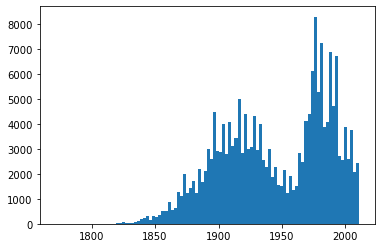

In [160]:
import matplotlib.pyplot as plt

# Histogram of all the opinions
plt.hist(opinions['year'], bins='auto');

In [89]:
# Occurrences of opinions by year
counts = opinions['year'].value_counts().sort_index()
counts

1771       1
1819       5
1820      12
1822      16
1823      11
        ... 
2007    1039
2008    1032
2009    1046
2010     988
2011     388
Name: year, Length: 193, dtype: int64

In [90]:
# Convert to dict
year_occ = counts.to_dict()
year_occ[2010]

988

In [161]:
def relative_freq(col):
    """
    col: pandas series containing year values
    Given a subset of opinions, compute the relative
    frequency for each year with respect to the 
    total number of occurrencies.
    """
    
    occurrencies = col.value_counts().sort_index().to_dict()
    frequencies = {}
    
    for key, value in occurrencies.items():
        rel_freq = value / year_occ[key]
        frequencies[key] = rel_freq
    
    return pd.DataFrame({'year': frequencies.keys(), 'count': frequencies.values()})

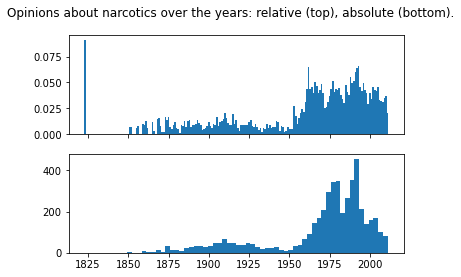

In [196]:
narc_freq = relative_freq(narc_docs['year'])

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Opinions about narcotics over the years: relative (top), absolute (bottom).')
ax1.bar(narc_freq['year'], narc_freq['count'], width=1)
ax2.hist(narc_docs['year'], bins='auto');

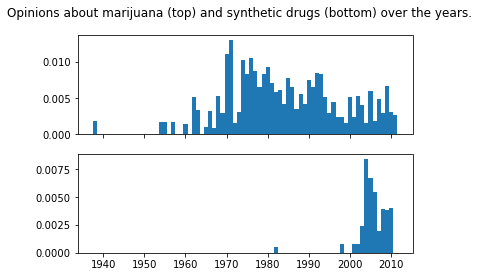

In [195]:
marij_docs = retrieve_docs(['marijuana', 'marihuana', 'cannabis'])
marij_freq = relative_freq(marij_docs['year'])

ecst_docs = retrieve_docs(['mdma', 'ecstasy', 'methamphetamine'])
ecst_freq = relative_freq(ecst_docs['year'])

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Opinions about marijuana (top) and synthetic drugs (bottom) over the years.')
ax1.bar(marij_freq['year'], marij_freq['count'], width=1)
ax2.bar(ecst_freq['year'], ecst_freq['count'], width=1);

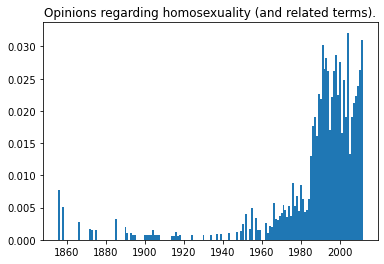

In [207]:
homosexual_terms = similar_terms(['homosexual'])
homosexual_docs = retrieve_docs(homosexual_terms)
homosexual_freq = relative_freq(homosexual_docs['year'])

plt.bar(homosexual_freq['year'], homosexual_freq['count'], width=1)
plt.title('Opinions regarding homosexuality (and related terms).');

## Correlation

In [221]:
def terms_corr(terms):
    """
    terms: list of terms
    Compute Pearson's correlation coefficient
    for terms, based on their tf idf scores.
    """
    
    indexes = []
    
    for term in terms:
        indexes.append(features.index(term))
        
    values = []
    
    for i, v in tqdm(enumerate(vectors)):
        vect = v.toarray()[0]
        values.append(vect[indexes])

    values = np.array(values)
    
    correlation = np.corrcoef(values, rowvar=False)
    
    return correlation

In [258]:
np.set_printoptions(precision=3, suppress=True)

corr = terms_corr(['gun', 'weapon', 'murder', 'male'])
corr

0it [00:00, ?it/s]

array([[1.   , 0.365, 0.22 , 0.061],
       [0.365, 1.   , 0.101, 0.045],
       [0.22 , 0.101, 1.   , 0.039],
       [0.061, 0.045, 0.039, 1.   ]])

In [261]:
from sklearn.cross_decomposition import CCA

def cca(group1, group2):
    """
    group1, group2: lists of terms
    Compute canonical correlation analysis
    between two groups of term, based on 
    their tf idf scores.
    """
    
    idx1 = []
    idx2 = []
    
    for term in group1:
        idx1.append(features.index(term))
        
    for term in group2:
        idx2.append(features.index(term))
        
    X = []
    Y = []
    
    for i, v in tqdm(enumerate(vectors)):
        vect = v.toarray()[0]
        X.append(vect[idx1])
        Y.append(vect[idx2])

    cca = CCA(n_components=2)
    cca.fit_transform(X, Y)
    
    return cca